In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as skm

In [81]:
data_path = os.path.join(os.getcwd(), 'results', 'npy','s')

data = []
for i in range(1,30):
    subj_path = data_path + str(i).zfill(2) + '.npy'
    subj = np.load(subj_path)
    if i == 1:
        columns = subj[0,:]
    col_1 = np.ones((subj.shape[0],1))*i
    subj = np.hstack((col_1,subj))
    data.append(subj[1:,:])

data = np.vstack(data)
data = data.astype(np.float64)
print(columns)
print(data.shape)

['bpm' 'ibi' 'sdnn' 'sdsd' 'rmssd' 'pnn20' 'pnn50' 'hr_mad' 'sd1' 'sd2'
 's' 'sd1/sd2' 'breathingrate' 'mean' 'std' 'me.1absdf' 'me.2absdf'
 'me.1df' 'me.2df' 'me.negdf' 'ro.negdf' 'num.argmi' 'num.argma' 'valence'
 'arousal' 'dominance' 'liking']
(1160, 28)


In [82]:
bad_idx = np.unique(np.where(np.isnan(data))[0])
data = np.delete(data,bad_idx,axis=0)
bad_idx = np.unique(np.where(np.isinf(data))[0])
data = np.delete(data,bad_idx,axis=0)

In [83]:
print(data.shape)

(1124, 28)


In [84]:
y = data[:,-4:]
data = data[:,:-4]

In [85]:
y[y<4.5] = 0
y[y>=4.5] = 1


In [90]:
# implements leave one (subject) out cross validation
prec = []
recall = []
f1 = []
acc = []
feature_importance = []
for j in np.unique(data[:,0]):
    row_idx = data[:,0] == j
    keep_idx = ~row_idx
    x_train = data[keep_idx,1:]
    y_train = y[keep_idx,0]
    x_val = data[row_idx,1:]
    y_val = y[row_idx,0]
    model = RandomForestClassifier(n_estimators=1000)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_val)
    acc.append(skm.accuracy_score(y_val,y_pred))
    f1.append(skm.f1_score(y_val,y_pred))
    prec.append(skm.precision_score(y_val,y_pred))
    recall.append(skm.recall_score(y_val,y_pred))
    feature_importance.append(model.feature_importances_)
    

Text(0.5, 1.0, 'Cross Validation Results')

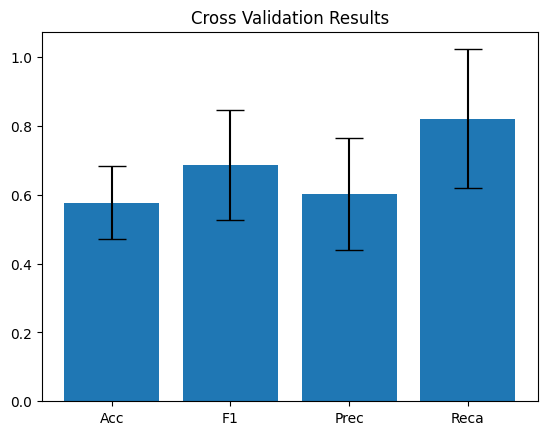

In [89]:
# plot performance results
acc_avg = np.mean(acc)
f1_avg = np.mean(f1)
prec_avg = np.mean(prec)
recall_avg = np.mean(recall)

acc_std = np.std(acc)
f1_std = np.std(f1)
prec_std = np.std(prec)
recall_std = np.std(recall)

means = [acc_avg,f1_avg,prec_avg,recall_avg]
errors = [acc_std,f1_std,prec_std,recall_std]
x_pos = np.arange(len(means))
mets = ['Acc','F1','Prec','Reca']

fig,ax = plt.subplots()
ax.bar(x_pos,means,yerr=errors,align='center',ecolor='black',capsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(mets)
ax.set_title('Cross Validation Results')


Text(0.5, 1.0, 'Feature Selection Results')

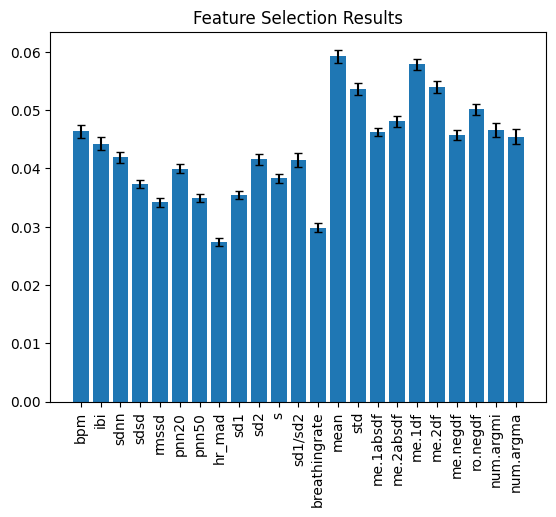

In [102]:
# plot feature importance results
feat_imps = np.vstack(feature_importance)
feat_imp_avg = feat_imps.mean(0)
feat_imp_std = feat_imps.std(0)

feat_names = columns[:23]
x_pos = np.arange(len(feat_names))

fig,ax = plt.subplots()
ax.bar(x_pos,feat_imp_avg,yerr=feat_imp_std,align='center',ecolor='black',capsize=3)
ax.set_xticks(x_pos)
ax.set_xticklabels(feat_names,rotation=90)
ax.set_title('Feature Selection Results')